In [1]:
import numpy as np
import pandas as pd
import random
import os

from sklearn.model_selection import train_test_split

In [2]:
def f_get_Normalization(X, norm_mode):    
    num_Patient, num_Feature = np.shape(X)
    
    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.nanstd(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))/np.nanstd(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.nanmin(X[:,j]))/(np.nanmax(X[:,j]) - np.nanmin(X[:,j]))
    else:
        print("INPUT MODE ERROR!")
    
    return X


def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask3 is required to get the contional probability (to calculate the denominator part)
        mask3 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask


def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss 
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category]. 
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements 
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask



##### TRANSFORMING DATA
def f_construct_dataset(df, feat_list):
    '''
        id   : patient indicator
        tte  : time-to-event or time-to-censoring
            - must be synchronized based on the reference time
        times: time at which observations are measured
            - must be synchronized based on the reference time (i.e., times start from 0)
        label: event/censoring information
            - 0: censoring
            - 1: event type 1
            - 2: event type 2
            ...
    '''

    grouped  = df.groupby(['id'])
    id_list  = pd.unique(df['id'])
    max_meas = np.max(grouped.count())[0]

    data     = np.zeros([len(id_list), max_meas, len(feat_list)+1])
    pat_info = np.zeros([len(id_list), 5])

    for i, tmp_id in enumerate(id_list):
        tmp = grouped.get_group(tmp_id).reset_index(drop=True)

        pat_info[i,4] = tmp.shape[0]                                   #number of measurement
        pat_info[i,3] = np.max(tmp['times'])     #last measurement time
        pat_info[i,2] = tmp['label'][0]      #cause
        pat_info[i,1] = tmp['tte'][0]         #time_to_event
        pat_info[i,0] = tmp['id'][0]      

        data[i, :int(pat_info[i, 4]), 1:]  = tmp[feat_list]
        data[i, :int(pat_info[i, 4]-1), 0] = np.diff(tmp['times'])
    
    return pat_info, data


def import_dataset(norm_mode = 'standard'):

    df_                = pd.read_csv('pbc2_cleaned.csv')

    bin_list           = ['drug', 'sex', 'ascites', 'hepatomegaly', 'spiders']
    cont_list          = ['age', 'edema', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic']
    feat_list          = cont_list + bin_list
    df_                = df_[['id', 'tte', 'times', 'label']+feat_list]
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains age at the last measurement
    label           = pat_info[:,[2]]  #two competing risks
    time            = pat_info[:,[1]]  #age when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 1.2) #or specifically define larger than the max tte
    num_Event       = len(np.unique(label)) - 1

    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    # DATA            = (data, data_org, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi

In [3]:
df = pd.read_csv('pbc2_cleaned.csv')

DIM, DATA, MASK, data_mi = import_dataset()

In [4]:
df.tail(15)

,id,tte,times,label,drug,age,sex,ascites,hepatomegaly,spiders,edema,serBilir,serChol,albumin,alkaline,SGOT,platelets,prothrombin,histologic
1930,309,237.0,184.0,0.0,0,58.301391,0,0.0,0.0,0.0,0,0.6,250.0,3.23,1054.0,90.0,188.0,11.7,3
1931,310,229.0,0.0,0.0,1,62.334355,0,0.0,0.0,0.0,1,1.7,434.0,3.35,1713.0,171.0,234.0,10.2,2
1932,310,229.0,38.0,0.0,1,62.334355,0,0.0,0.0,0.0,1,1.7,516.0,3.24,1661.0,82.0,249.0,9.9,3
1933,310,229.0,89.0,0.0,1,62.334355,0,0.0,1.0,0.0,1,2.2,386.0,2.94,1808.0,81.0,268.0,10.9,3
1934,310,229.0,141.0,0.0,1,62.334355,0,0.0,1.0,0.0,1,1.4,367.0,2.71,1584.0,72.0,260.0,11.3,3
1935,310,229.0,193.0,0.0,1,62.334355,0,0.0,1.0,0.0,1,1.8,364.0,3.19,1350.0,65.0,272.0,11.3,3
1936,311,215.0,0.0,0.0,1,37.999671,0,0.0,0.0,0.0,0,2.0,247.0,3.16,1050.0,117.0,335.0,10.5,2
1937,311,215.0,27.0,0.0,1,37.999671,0,0.0,NaN,NaN,0,1.5,NaN,3.41,2562.0,123.0,382.0,10.5,2
1938,311,215.0,57.0,0.0,1,37.999671,0,0.0,0.0,0.0,0,1.9,424.0,3.57,2516.0,166.0,408.0,10.6,3
1939,311,215.0,157.0,0.0,1,37.999671,0,0.0,0.0,0.0,0,0.6,391.0,3.40,2322.0,191.0,337.0,11.4,3


In [5]:
labels = np.reshape(DATA[2],-1)
time = np.reshape(DATA[1],-1)

In [6]:
features = np.zeros([312,256])

In [7]:
np.shape(features)

(312, 256)

In [8]:
np.shape(np.reshape(DATA[0][0],-1))

(256,)

In [9]:
for id in range(312):
    features[id] = np.reshape(DATA[0][id],-1)

In [10]:
# RSF implementaion
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [11]:
X = features

In [12]:
y = []
for l,t in zip(labels,time):
    y.append((l,t))

In [13]:
y = np.array(y,dtype = np.dtype('bool,float'))

In [14]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state)


In [15]:
X_train

array([[28.        ,  0.74683102, -0.57542067, ...,  0.        ,
         0.        ,  0.        ],
       [28.        , -0.80593702, -0.57542067, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  2.72882171,  2.58168288, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [31.        , -0.65079631,  1.0031311 , ...,  0.        ,
         0.        ,  0.        ],
       [27.        , -1.05770046, -0.57542067, ...,  0.        ,
         0.        ,  0.        ],
       [23.        , -1.07974678, -0.57542067, ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
type(y)

numpy.ndarray

In [17]:
X2, y2 = load_gbsg2()
y2[0]

(True, 1814.)

In [18]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [19]:
rsf.score(X_test, y_test)

0.8662037037037037

In [20]:
pd.Series(rsf.predict(X))

0      139.181004
1       29.656901
2       72.107405
3       77.079778
4       73.517853
          ...    
307     33.049464
308     33.963387
309     51.366700
310     45.555855
311    104.182945
Length: 312, dtype: float64

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

surv = rsf.predict_survival_function(X, return_array=True)

rsf_predictions = {}
for i, s in enumerate(surv):
    rsf_predictions[i] = s
#     plt.step(rsf.event_times_, s, where="post", label=str(i))
# plt.ylabel("Survival probability")
# plt.xlabel("Time in days")
# plt.legend()
# plt.grid(True)

In [31]:
rsf_predictions['event_times'] = rsf.event_times_

In [32]:
rsf_predictions[311]

array([0.99446012, 0.98415882, 0.97804566, 0.96798461, 0.96343157,
       0.95940392, 0.95532431, 0.9519453 , 0.94489624, 0.94172123,
       0.93813307, 0.93181631, 0.92570717, 0.92123499, 0.91825722,
       0.91329586, 0.91158266, 0.90034319, 0.89452268, 0.88902688,
       0.88757013, 0.88410654, 0.85682745, 0.84734306, 0.84088471,
       0.82237027, 0.82024334, 0.80412806, 0.78206852, 0.77266072,
       0.76334283, 0.75663086, 0.75135496, 0.74229947, 0.73219731,
       0.72025393, 0.7024212 , 0.70060785, 0.6896428 , 0.68172129,
       0.65387442, 0.63567467, 0.63019517, 0.61882895, 0.60529713,
       0.59156325, 0.58569367, 0.57300005, 0.57064743, 0.5625074 ,
       0.54867183, 0.53468715, 0.52556244, 0.52074168, 0.50955242,
       0.50622881, 0.4998954 , 0.49330599, 0.47897447, 0.46926736,
       0.46189443, 0.45540581, 0.43813048, 0.42900678, 0.42615771,
       0.41830228, 0.40866098, 0.40385243, 0.40130252, 0.38611839,
       0.38466702, 0.38285682, 0.36903402, 0.36657517, 0.36284

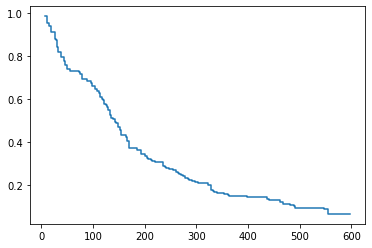

In [29]:
plt.step(rsf.event_times_, rsf_predictions[0], where="post", label=str(i))

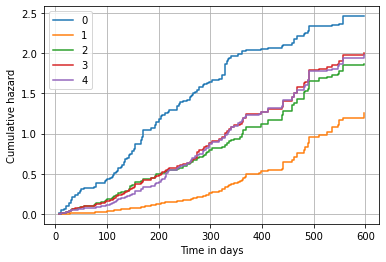

In [30]:
surv = rsf.predict_cumulative_hazard_function(X[:5], return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [37]:
import pickle
pickle.dump( rsf_predictions, open( "patient_surv_functions/rsf.p", "wb" ) )

In [38]:
rsf_predictions = pickle.load( open( "patient_surv_functions/rsf.p", "rb" ) )
print(rsf_predictions[0])

[0.98355465 0.95081897 0.94033442 0.9101994  0.89174421 0.87809435
 0.87507039 0.85473153 0.84215615 0.8166226  0.79253051 0.77678434
 0.75715935 0.73994503 0.7287191  0.72531001 0.71666648 0.69074893
 0.68439599 0.67241397 0.66064636 0.65723279 0.64654641 0.63661285
 0.62504271 0.60672683 0.59791499 0.59317027 0.574243   0.57061994
 0.56220101 0.54998502 0.53176441 0.52285465 0.51048515 0.50499657
 0.49103898 0.48537485 0.46990506 0.45707609 0.44539867 0.43044596
 0.42164767 0.41343655 0.40187199 0.37150653 0.3712378  0.36637924
 0.3629361  0.3523143  0.34132979 0.33354262 0.32788769 0.32635148
 0.32050789 0.31556429 0.31318145 0.31097094 0.30471686 0.29914277
 0.28947708 0.28128675 0.27641387 0.27391617 0.27080273 0.26190585
 0.26064037 0.25411327 0.24961782 0.2469519  0.23904011 0.22994274
 0.22548748 0.22162884 0.21966835 0.21832497 0.21498626 0.21433422
 0.20884761 0.20666067 0.19905111 0.17789183 0.1702973  0.16823246
 0.16533575 0.16122955 0.16072677 0.15751743 0.15643262 0.1514